In [106]:
from qutip import *
import numpy as np
import scipy
import cmath
import matplotlib.pyplot as plt
from numpy.random import seed
from numpy.random import rand
from itertools import product
from scipy.misc import derivative
from scipy import optimize
seed(1)

In [107]:
#operator definitionis
N = 2
si = qeye(2)
sx = 0.5*sigmax()
sy = 0.5*sigmay()
sz = 0.5*sigmaz()

In [108]:
#make list of tensor products
sx_list = []
sy_list = []
sz_list = []

for n in range(N):
    op_list = []
    for m in range(N):
        op_list.append(si)

    op_list[n] = sx
    sx_list.append(tensor(op_list))

    op_list[n] = sy
    sy_list.append(tensor(op_list))

    op_list[n] = sz
    sz_list.append(tensor(op_list))


In [109]:
#Construct Hamiltonian
B = 0
A0 = 1
H = B*sz_list[0] 
for n in range(N-1):
    H += A0*sz_list[0]*sz_list[n+1] + A0*sx_list[0]*sx_list[n+1] + A0*sy_list[0]*sy_list[n+1]
print(H)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.25  0.    0.    0.  ]
 [ 0.   -0.25  0.5   0.  ]
 [ 0.    0.5  -0.25  0.  ]
 [ 0.    0.    0.    0.25]]


In [110]:
#Find Groundstate
H.groundstate()

(-0.7500000000000001,
 Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[ 0.        ]
  [ 0.70710678]
  [-0.70710678]
  [ 0.        ]])

In [111]:
#Make basis
Sbasis = []
for i in range(N):
    for j in range(N):
        Sbasis.append(tensor([basis(N,i),basis(N,j)]))
print(Sbasis)

[Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]], Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]
 [0.]], Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [1.]
 [0.]], Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [1.]]]


In [112]:
#get sz values for basis states
sz = np.zeros((2**N,N), dtype = complex)
a = [[1 for j in range(N)] for i in range(2**N)]
for i in range(2**N):
    for j in range(N):
        #matrix element <bra|Sz|ket>
        sz[i][j] = sz_list[j].matrix_element(Sbasis[i],Sbasis[i])

print(sz)

[[ 0.5+0.j  0.5+0.j]
 [ 0.5+0.j -0.5+0.j]
 [-0.5+0.j  0.5+0.j]
 [-0.5+0.j -0.5+0.j]]


In [140]:
#Define RBM Parameters
M = 2
alp = M/N
#Number of parameters 
num = N+M+N*M

par = np.random.rand(2*num)
# par = np.array([0,0,0,0,0,0,0,0,0,0,0.5*np.pi,0.25*np.pi,0.5*np.pi,-1.5*np.pi,0,-0.5*np.pi])




In [141]:
#Function to give RBM wavefuntion
def RBM_ansatz(par, Sbasis, N, M,sz):
    #make parmeters complex
    parC = np.vectorize(complex)(par[:num],par[num:])
    a = parC[:N]
    b = parC[N:N+M]
    W = parC[N+M:].reshape(N,M)
    expTerm = np.zeros(2**N, dtype = complex)
    coshTerm = np.zeros((M,2**N), dtype = complex)
    hidProduct = np.zeros(2**N, dtype = complex)
    psiMValues = np.zeros(2**N, dtype = complex)
    psiM = 0*Sbasis[0]

    for i in range(2**N):
        for m in range(M):
            coshTerm[m][i] = 2*np.cosh(np.dot(W[m],sz[i]) + b[m])
    hidProduct = np.prod(coshTerm, axis = 0) 
  
    
    for i in range(2**N):
        expTerm[i] = np.exp(np.dot(a,sz[i]))
        psiMValues[i] = expTerm[i]*hidProduct[i]
        psiM += psiMValues[i]*Sbasis[i]
    psiNorm = psiM.unit()
    return psiNorm

test = RBM_ansatz(par, Sbasis, N, M,sz)
test


Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[-0.28840261+0.7155085j ]
 [ 0.26974452-0.0170216j ]
 [ 0.48791416+0.27790497j]
 [ 0.11413888-0.05916577j]]

In [142]:
#Variation Energy Definition
def varEnergy(par, Sbasis, N, M,sz, H):
    psiM = RBM_ansatz(par, Sbasis, N, M, sz)
    E = expect(H,psiM)
    norm = psiM.norm()**2
    Enorm = E/norm
    return Enorm

varEnergy(par, Sbasis, N, M,sz, H)

0.18271016358185904

In [143]:
#Energy Partials
def gradEnergy(par, Sbasis, N, M,sz, H):
    eps = 0.001
    return optimize.approx_fprime(par,varEnergy,eps,Sbasis, N, M,sz, H)

In [144]:
#Gradient Descent
def gradDescent(par, Sbasis, N, M,sz, H):
    min = scipy.optimize.fmin_cg(varEnergy,par,args= (Sbasis,N,M,sz,H),full_output=True, retall = True, disp=True)
    print('==================== Descent Evaluation ====================')
    print('RBM Parameters: ',min[0])
    print('Minimum Energy: ', min[1])
    
    if min[4] == 1:
        print("The maximum number of iterations was exceeded")
    return min
    
    

In [149]:
y = gradDescent(par, Sbasis, N, M,sz, H)[5]

Optimization terminated successfully.
         Current function value: -0.750000
         Iterations: 23
         Function evaluations: 864
         Gradient evaluations: 48
==================== Descent Evaluation ====================
RBM Parameters:  [ 0.26656127  0.64249412 -0.1534339   0.04423439 -1.25259669  0.94567741
 -1.05339972  0.96491856 -0.44793588  1.42393011 -0.2440295   0.88779614
  1.11890899  1.53449368  0.07326377  1.29275232]
Minimum Energy:  -0.7499999997990487


In [150]:
#Ground State
final=RBM_ansatz(min[0], Sbasis, N, M,sz)
final.unit()

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.00485064+0.00229102j]
 [-0.70846809-0.02607789j]
 [ 0.70469763+0.02555763j]
 [ 0.00173935+0.01044825j]]

In [151]:
#Minimum Energy 
varEnergy(min[0], Sbasis, N, M,sz, H)

-0.7498517876507512

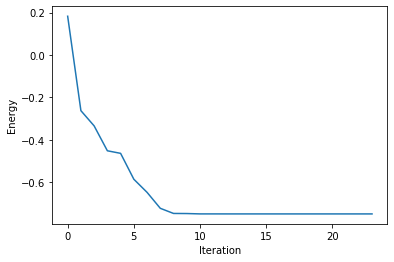

In [152]:
numIter = len(y)
iter = np.arange(numIter)
energy = np.zeros(numIter)
for i in range(numIter):
    energy[i]= varEnergy(y[i], Sbasis, N, M,sz, H)
plt.plot(iter, energy)
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.show()
